# Structural Optimization of a wingbox

In the previous notebook we have seen the structural analysis of a single wingbox cell. We would like however to use these tools to optimize the various parameters of the wingbox in order to minimize the weight of the structure. In order to do so let's remind ourselves what exactly we can change in order to improve the performance of this wingbox.

In the previous notebook we had defined the following parameters in order to perform the analysis.

- $n_{cell}$    - Number of cells
- $\text{loc}_{sp}$    - The location of the spars
- $t_{sk}$      - The thickness of the skin in each cell
- $A_{str}$     - The area of the stringers
- $t_{sp}$      -  The thickness of the spars
- $n_{str}$     - The amount of stringers per cell


These variables were then loaded in the API data structure as shown below:

```C
attr_dict = {
    "n_cell":4,
    "spar_loc_nondim":[0.3, 0.5, 0.7],
    "t_sk_cell":[0.002,0.004,0.004, 0.004],
    "area_str":20e-6,
    "t_sp":0.008,
    "str_cell":[8,8,7,8]
}

wingbox_struct = tud.Wingbox(**attr_dict)
```

However, there will be one major change. For the structural analysis of a wingbox only the stringer area is relevant however for the constraints the geometry of said stringers is also important as you will see further up in this notebook.

So in the optimization of the wingbox we wil add the stringer height, width and thickness to the optimization parameters.

The parameters which we will optimize for are the skin thickness in each cell, the area of the stringers, the thickness of the spars and finally the stringer of the cell. This leaves the amount of cells, the spar locations and the bay length to be decided by the designers. The reasoning behind this is that usually your rib and spar locations are constrained the  placement of other systems in the wing such as the flap and slat mechanism. Below a summary can be found of the fixed and optimization parameters:


| **Optimiziation Parameters**         	| **Fixed Parameters** 	|
|--------------------------------------	|----------------------	|
| Skin thickness in each cell          	| The amount of cells  	|
| Stringer width                       	| Spar locations       	|
| Stringer height                       	|   Bay length|
| Stringer thickness                       	|   	|
| Spar thickness                       	|         	|
| The amount of stringers in each cell 	|                      	|



# Laying out a framework for a full wing optimization

In order define our constraints later on we will have to divide the wing in sections called bays. Each bay is enclosed by two ribs, thus the length of these bays is for the designer to decide. Once, a bay is defined, we can further split this up in a collection of flat sheets. Where each sheet is in turn enclosed by stringers. The boundary conditions for these stringers have been decided to be simply supported. In [figure 1](#figure1) we can see the result of the partitioning that was just described. Although we will not model the effects of taper (Future implementation).

<br>
<p align="left"  id="figure1" >
<img src="https://github.com/saullocastro/tuduam/blob/main/doc/_static/wing_bay_sheet.png?raw=true" width="600" />
 <br>
</p>
<p align="left">
<em>Figure 1: Wing modeled as a combination of simply supported sheets and simply supported bays. Figure taken from T.H.G Megson, Aircraft  Structures For Engineering Students</em>
</p>
<br>

Now that our wing has been divided into bays, and the bays respectively into sheets we can limit the scope of the optimization. Instead, of optimizing for the entire wing simultaneously we will optimize each bay. In [figure 2](#figure2) an overview is found on how the optimization in this notebook will tackle the sizing of the structural members in the wing.

<br>
<p align="left"  id="figure2" >
<img src="https://raw.githubusercontent.com/saullocastro/tuduam/6e2a96b1fd444969175b2b61de6eb1fc9b94a9d5/doc/_static/Optimization_procedure.svg" width="600" style="background-color: white;"/>
 <br>
</p>
<p align="left">
<em>Figure 2: An overview of the optimization procedure for an entire wing.  </em>
</p>
<br>

The following sections will now enclose how to optimize a single one of these bays, starting with constraining the design space.

# Constraining the design

During the optimization it is important we set the minimum constraints the design should meet. Otherwise, the optimum solution would be no wingbox at all. For the API documentation of all these constraints please visit [constraints documentation](https://saullocastro.github.io/tuduam/constraints.html). We'll cover the most important ones in this document and link to the documentation for the remainder of the constraints.

### Buckling

As previously discussed, a section of the wingbox is divided up in plates. Knowing these plates are simply supported we can compute the critical instability in both shear and compression using  equations 1 and 2, respectively:

$$
\tag{1}
\sigma_{cr} = k_b  \frac{pi^2 E}{12(1 - \nu)} \left(\frac{t_{sk}}{b}\right)^2
$$

$$
\tag{2}
\sigma_{cr} = k_c  \frac{pi^2 E}{12(1 - \nu)} \left(\frac{t_{sk}}{b}\right)^2
$$

For the specifics on $k_b$ and $k_c$, please review the [API documentation](https://saullocastro.github.io/tuduam/).

Whilst, we could simply apply them individually these two critical loads are not independent from each other. In increased shear loading, decreases the compression capability of the sheet. Hence, we use an interaction curve as described in equation 3.

$$
\tag{3}
\frac{N_x}{N_{x,crit}} + \left(\frac{N_{xy}}{N_{xy,crit}}\right)^2 < 1
$$

In equation 3, $N_{x,crit}$ is computed with equation 2 and $N_{xy,crit}$ with equation 1. $N_x$ and $N_{xy}$ are the loads specified by the user.

Finally, we also constrain the design using global skin buckling as a stiffened panel can also buckle as a whole.
In this case, the width of the panel is utilized instead of the stringer pitch, and simply supported conditions
can be assumed. The contribution of the stringers that still provide a stiffening effect can be considered by
smearing their thickness to the skin thickness, as in Equation 47.

$$
\tag{47}
t_{smeared} = \frac{t_{sk} \cdot b + N_{str} \cdot A_{st}}{b}
$$

The smeared thickness is substituted in the equation for critical sheet compression.
The constraint is expressed below.

$$
\sigma_{cr,glob} - \sigma_{cr,loc} \geq 0
$$


### Von Mises failure Criterion


Besides buckling we also do not want the wingbox to yield. Hence we also apply the von Mises yield criterion. Considering the direct stresses and plane stresses that occur in the wingbox we can derive equation 4.




$$
\begin{align*}
\sigma_y & \geq  \sigma_v \\
\tag{4}
\sigma_y    & \geq  \sqrt{\sigma_{11}^2 + 3\tau^2} \\
\end{align*}
$$

Abiding by this constraint ensures that the wingbox does not yield under the expected loads.

### Other constraints

- [Column Stringer buckling](https://saullocastro.github.io/tuduam/constraints.html#tuduam.structures.constraints.IsotropicWingboxConstraints.column_str_buckling)
- [Crippling](https://saullocastro.github.io/tuduam/constraints.html#tuduam.structures.constraints.IsotropicWingboxConstraints.crippling)
- [Stringer Flange Buckling](https://saullocastro.github.io/tuduam/constraints.html#tuduam.structures.constraints.IsotropicWingboxConstraints.stringer_flange_buckling) (similar to buckling of sheet, except different BC's)




# Leveraging Python for the optimization

In order to leverage Python for our optimization, we will first have to install two libraries into the `google collab` environment. These are `tuduam` and `pymoo`, tuduam is a library specifically tailored for this course and pymoo a library for multi-objective optimization. Please run the code cell below in order to do.

In [7]:
!pip install tuduam
!pip install pymoo
!git clone https://github.com/saullocastro/tuduam.git
# If the following error occurs "fatal: destination path 'tuduam' already exists and is not an empty directory." please continue as your environment is already set up correctly

# Initialisation of parameters

To start the initialisation of the optimisation that we are going to perform  there are a two parameters that require a definition as these are designer choices.

In [8]:
import os
import tuduam
from tuduam.data_structures import Wingbox, Material




attr_dict = {
    "n_cell":4,
    "spar_loc_nondim":[0.3, 0.5, 0.75],
    "str_cell": [9,7,9,8]
}

mat_dict = {
        "young_modulus":3e9,
        "shear_modulus":80e9,
        "safety_factor":1.5,
        "load_factor":1.0,
        "poisson":0.3,
        "density":1600,
        "beta_crippling":1.42,
        "sigma_ultimate":407000000.0,
        "sigma_yield":407000000.0,
        "g_crippling":5
    }

mat_struct = Material(**mat_dict)
wingbox_struct = Wingbox(**attr_dict)

Having this definitnon we can now start the optimization. Before continuing it is probably useful to first take a look through the API documentation for the class and its methods that we will be using. The class that we will be using is `SectionOpt` which is situated in the `structures`subpackage in tuduam. The link to the [API docs](https://saullocastro.github.io/tuduam/optimization.html#tuduam.structures.optimization.SectionOpt) can be found here.

Before iterating for an entire wing, let us first do an example for a single section. We'll take a section of the wing where the mean chord, $\bar{c} = 2$ and the length of this section $b = 1.2$. For the airfoil, we'll use th NACA 4412. For the amount of cells and spar locations we'll use the previously defined values.

In [9]:
from tuduam.structures import SectionOpt

chord = 3 # Chord length
coord_path = os.path.realpath(os.path.join(os.path.abspath('.'), 'tuduam', 'examples', 'naca_4412.txt')) # Path to airfoil coordinates
len_sec = .2 # Lenght of the section

opt_obj = SectionOpt(coord_path, chord, len_sec, wingbox_struct, mat_struct)

Remember figure 2 which portrayed the top view of the optimization loop. Let us start at the core, i.e the optimization that is run for a fixed amount of stringers. For us these stringers were defined `wingbox_struct`. This optimization in the library is defined in the method `GA_optimize`, here you can find the [specifics](https://saullocastro.github.io/tuduam/optimization.html#tuduam.structures.optimization.SectionOpt.GA_optimize).

Let's run the optimization below with some typical values for the loads! Also note that we specify the upper and lower boundsFeel free to alter them and watch the design change.


In [10]:
import numpy as np

shear_y = 30e3
shear_x = 15000
moment_y = 4e2
moment_x = 30e3
applied_loc = 0.45
opt = SectionOpt(coord_path, chord, len_sec, wingbox_struct, mat_struct)

upper_bnds = 8*[0.012]
lower_bnds = 4*[0.0001] +  [0.003] + [0.001] + 2*[0.003]
res =  opt.GA_optimize(shear_y, shear_x, moment_y, moment_x, applied_loc, upper_bnds, lower_bnds, pop=20, n_gen= 60,multiprocess=True, verbose= True)

print(f"\n\n======== Results ==========")
print(f"Skin thickness = {np.array(res.X[:4])*1000} mm" )
print(f"Spar thickness = {res.X[4]*1000} mm")
print(f"Stringer thickness = {res.X[5]*1000} mm")
print(f"Stringer  width= {res.X[6]*1000} mm")
print(f"Stringer height = {res.X[7]*1000} mm")

# res =  opt_obj.full_section_opt(, pop=100, pop_full= 10, n_gen= 5 ,n_gen_full= 2)

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\damie\\OneDrive\\Desktop\\Damien\\UAM_course\\tuduam\\doc\\source\\notebooks\\tuduam\\examples\\naca_4412.txt'

We can also get to know more about the history of each iteration through the `res` variable which is an instance of the `pymoo.core.result.Result`class. In this class the objective functions is described with `F` and the design vector with `X`. The object contains the history of each generation which we can access like shown below where we access the first generation.

In [ ]:
pop_lst = [gen.pop for gen in res.history]
print("Generation 1\nt_sk_cell1 - t_sk_cell2 - t_sk_cell3 - t_sk_cell4 - t_sp -  t_st - w_st - h_st")
print(f"=====================================================================\n\n {pop_lst[0].get('X')}")


Generation 1
t_sk_cell1 - t_sk_cell2 - t_sk_cell3 - t_sk_cell4 - t_sp -  t_st - w_st - h_st

 [[0.00506256 0.00867186 0.00010136 0.00369776 0.0043208  0.00201572
  0.00467634 0.00611005]
 [0.00482153 0.00651192 0.00508841 0.00825411 0.00484007 0.01065929
  0.00324649 0.00903421]
 [0.00506593 0.00674841 0.0017706  0.00245741 0.0102067  0.01165088
  0.00582082 0.0092309 ]
 [0.01052903 0.01074582 0.00111203 0.00056475 0.00452847 0.01065957
  0.00388512 0.00678997]
 [0.01149889 0.00644467 0.00833334 0.00385464 0.00917851 0.01018088
  0.00316459 0.0097513 ]
 [0.01186745 0.00900317 0.00343728 0.00949242 0.00392903 0.00592683
  0.01117736 0.00564253]
 [0.00352453 0.00164734 0.00033047 0.00817814 0.00490465 0.00392101
  0.00742416 0.00348026]
 [0.006932   0.00184607 0.00711274 0.00842712 0.00392101 0.00555462
  0.0092496  0.00672761]
 [0.00069445 0.00647717 0.00799916 0.00622718 0.01150135 0.00745211
  0.01113062 0.00423727]
 [0.00175739 0.00970796 0.00483235 0.00206771 0.01134758 0.00482542
 

We can also plot the average value of variables over time and optimization function over time, this gives us an idea of how the variables effect the design. Run the code below:

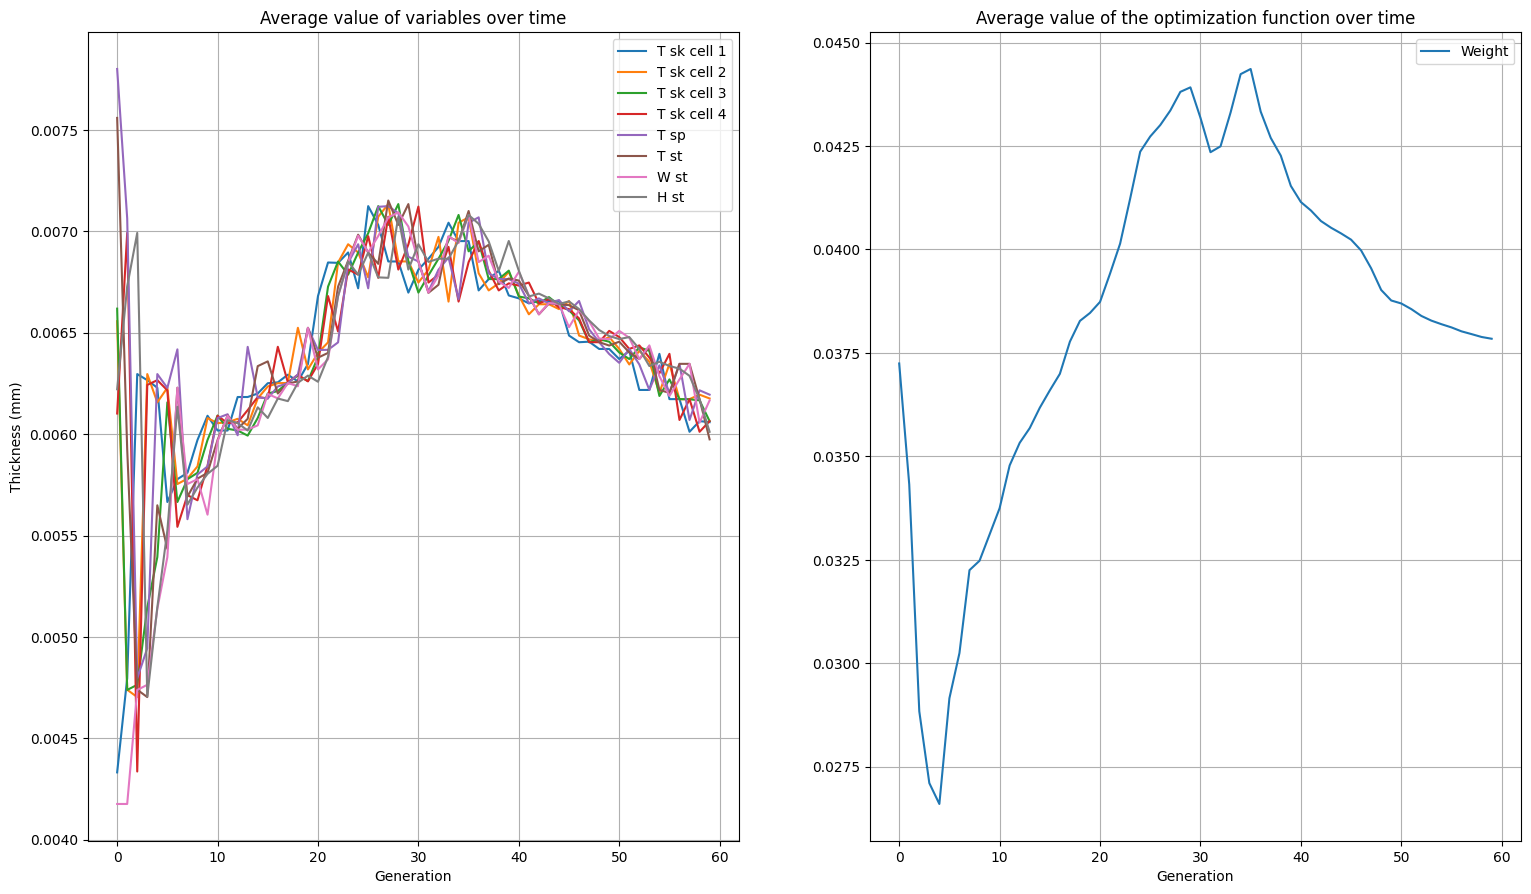

In [ ]:
import matplotlib.pyplot as plt

t_sk_cell1_lst = [np.average(pop.get("X")[:][0]) for pop in pop_lst]
t_sk_cell2_lst = [np.average(pop.get("X")[:][1]) for pop in pop_lst]
t_sk_cell3_lst = [np.average(pop.get("X")[:][2]) for pop in pop_lst]
t_sk_cell4_lst = [np.average(pop.get("X")[:][3]) for pop in pop_lst]
t_sp_lst = [np.average(pop.get("X")[:][4]) for pop in pop_lst]
t_st_lst = [np.average(pop.get("X")[:][5]) for pop in pop_lst]
w_st_lst = [np.average(pop.get("X")[:][6]) for pop in pop_lst]
h_st__lst = [np.average(pop.get("X")[:][7]) for pop in pop_lst]

f_lst = [np.average(pop.get("F")) for pop in pop_lst]

fig, (ax1, ax2) = plt.subplots(1, 2)
fig.set_size_inches(18.5, 10.5)

ax1.plot(t_sk_cell1_lst, label="T sk cell 1")
ax1.plot(t_sk_cell2_lst, label="T sk cell 2")
ax1.plot(t_sk_cell3_lst, label="T sk cell 3")
ax1.plot(t_sk_cell4_lst, label="T sk cell 4")
ax1.plot(t_sp_lst, label="T sp")
ax1.plot(t_st_lst, label="T st")
ax1.plot(w_st_lst, label="W st")
ax1.plot(h_st__lst, label="H st")

ax2.plot(f_lst, label="Weight")

ax1.set_title("Average value of variables over time")
ax2.set_title("Average value of the optimization function over time")


ax1.set_xlabel("Generation")
ax2.set_xlabel("Generation")
ax1.set_ylabel("Thickness (mm)")
ax1.legend()
ax2.legend()
ax1.grid()
ax2.grid()

plt.show()




As you can see, it gets quite messy with all variables in there. One could also argue the information gets lost when taking the average and only plotting the optimum solution would give a better idea. It is left up to the reader to implement this.

# Changing the amount of stringers

In the previous optimization we only optimzied for the various thicknesses, however a better solution would be possible when different configuration of stringers are used, or even a different layout of ribs.

`tuduam` also provides a method for optimizing for different stringer configuration. This is the outer optimization loop as has been shown earlier in this notebook in figure 2. The API documentation for this functionality can be found [here](https://saullocastro.github.io/tuduam/optimization.html#tuduam.structures.optimization.SectionOpt.full_section_opt). `SectionOpt.full_section_opt` interally also used the optimization which we experimented with previously. However, it calls this function for every stringer configuration, hence it is signficantly more computationally expensive.

The method does come with a `multiprocess` flag which does allow it to see major performance boosts on more powerful platforms. So feel free to give it a try on your local machine. The setup is very similar to `GA_optimize`.

This repository does **not** implememt an optimization of the spanwise rib distribution.
